In [1]:
import dataclasses
import os
import pathlib
import pickle
import queue
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.animation as animation
import numpy as np
import wandb
from matplotlib import pyplot as plt

from cleanba import cleanba_impala
from cleanba.cleanba_impala import make_optimizer, unreplicate
from cleanba.environments import BoxobanConfig, EnvConfig
from cleanba.network import Policy
import json
import flax
import farconf
from flax.training.train_state import TrainState
from cleanba.config import Args


wandb.init(mode="disabled")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [2]:
@dataclasses.dataclass
class EvalConfig:
    env: EnvConfig
    n_episode_multiple: int = 1
    steps_to_think: list[int] = dataclasses.field(default_factory=lambda: [0])
    temperature: float = 0.0

    safeguard_max_episode_steps: int = 30000

    def run(self, policy: Policy, get_action_fn, params, *, key: jnp.ndarray) -> dict[str, float]:
        key, env_key, carry_key, obs_reset_key = jax.random.split(key, 4)
        env_seed = int(jax.random.randint(env_key, (), minval=0, maxval=2**31 - 2))
        envs = dataclasses.replace(self.env, seed=env_seed).make()
        max_steps = min(self.safeguard_max_episode_steps, self.env.max_episode_steps)

        episode_starts_no = jnp.zeros(envs.num_envs, dtype=jnp.bool_)

        metrics = {}
        try:
            for steps_to_think in self.steps_to_think:
                all_episode_returns = []
                all_episode_lengths = []
                all_episode_successes = []
                all_obs = []
                all_acts = []
                all_rewards = []
                all_level_infos = []
                envs = dataclasses.replace(self.env, seed=env_seed).make()
                reset_key = None
                for _ in range(self.n_episode_multiple):
                    reset_key, sub_reset_key = jax.random.split(obs_reset_key if reset_key is None else reset_key)
                    reset_seed = int(jax.random.randint(sub_reset_key, (), minval=0, maxval=2**31 - 2))
                    obs, level_infos = envs.reset(seed=reset_seed)
                    # reset the carry here so we can use `episode_starts_no` later
                    carry = policy.apply(params, carry_key, obs.shape, method=policy.initialize_carry)

                    # Update the carry with the initial observation many times
                    for think_step in range(steps_to_think):
                        carry, _, _, key = get_action_fn(
                            params, carry, obs, episode_starts_no, key, temperature=self.temperature
                        )

                    eps_done = np.zeros(envs.num_envs, dtype=np.bool_)
                    episode_success = np.zeros(envs.num_envs, dtype=np.bool_)
                    episode_returns = np.zeros(envs.num_envs, dtype=np.float64)
                    episode_lengths = np.zeros(envs.num_envs, dtype=np.int64)
                    episode_obs = np.zeros((max_steps+1, *obs.shape), dtype=np.int64)
                    episode_acts = np.zeros((max_steps, envs.num_envs), dtype=np.int64)
                    episode_rewards = np.zeros((max_steps, envs.num_envs), dtype=np.float64)
                    
                    episode_obs[0] = obs
                    i = 0
                    while not np.all(eps_done):
                        if i >= self.safeguard_max_episode_steps:
                            break
                        carry, action, _, key = get_action_fn(
                            params, carry, obs, episode_starts_no, key, temperature=self.temperature
                        )

                        cpu_action = np.asarray(action)
                        obs, rewards, terminated, truncated, infos = envs.step(cpu_action)
                        episode_returns[~eps_done] += rewards[~eps_done]
                        episode_lengths[~eps_done] += 1
                        episode_success[~eps_done] |= terminated[~eps_done]  # If episode terminates it's a success

                        episode_obs[i+1, ~eps_done] = obs[~eps_done]
                        episode_acts[i, ~eps_done] = cpu_action[~eps_done]
                        episode_rewards[i, ~eps_done] = rewards[~eps_done]

                        # Set as done the episodes which are done
                        eps_done |= truncated | terminated
                        i += 1

                    all_episode_returns.append(episode_returns)
                    all_episode_lengths.append(episode_lengths)
                    all_episode_successes.append(episode_success)

                    all_obs += [episode_obs[:episode_lengths[i], i] for i in range(envs.num_envs)]
                    all_acts += [episode_acts[:episode_lengths[i], i] for i in range(envs.num_envs)]
                    all_rewards += [episode_rewards[:episode_lengths[i], i] for i in range(envs.num_envs)]

                    all_level_infos.append(level_infos)

                all_episode_returns = np.concatenate(all_episode_returns)
                all_episode_lengths = np.concatenate(all_episode_lengths)
                all_episode_successes = np.concatenate(all_episode_successes)
                all_level_infos = {k: np.concatenate([d[k] for d in all_level_infos])
                                    for k in all_level_infos[0].keys() if not k.startswith("_")}

                metrics.update(
                    {
                        f"{steps_to_think:02d}_episode_returns": float(np.mean(all_episode_returns)),
                        f"{steps_to_think:02d}_episode_lengths": float(np.mean(all_episode_lengths)),
                        f"{steps_to_think:02d}_episode_successes": float(np.mean(all_episode_successes)),
                        f"{steps_to_think:02d}_num_episodes": len(all_episode_returns),
                        f"{steps_to_think:02d}_all_episode_info": dict(
                            episode_returns=all_episode_returns,
                            episode_lengths=all_episode_lengths,
                            episode_successes=all_episode_successes,
                            episode_obs=all_obs,
                            episode_acts=all_acts,
                            episode_rewards=all_rewards,
                            level_infos=all_level_infos,
                        ),
                    }
                )
        finally:
            envs.close()
        return metrics

def save_level_video(level_idx, base_dir="./", force=False):
    base_dir = pathlib.Path(base_dir)
    base_dir.mkdir(parents=True, exist_ok=True)
    file_path = base_dir / f'{level_idx}.mp4'
    if file_path.exists() and not force:
        return
    obs_baseline = np.moveaxis(val_all_episode_info[baseline_steps]["episode_obs"][level_idx], 1, 3)
    obs_best = np.moveaxis(val_all_episode_info[best_steps]["episode_obs"][level_idx], 1, 3)
    num_obs_baseline = len(obs_baseline)
    num_obs_best = len(obs_best)
    max_obs = max(num_obs_baseline, num_obs_best)
    fig, axs = plt.subplots(1, 2)
    ax1, ax2 = axs
    ax1.set_title(f"{steps_to_think[baseline_steps]} think steps")
    ax2.set_title(f"{steps_to_think[best_steps]} think steps")
    im1 = ax1.imshow(obs_baseline[0])
    im2 = ax2.imshow(obs_best[0])
    title = fig.suptitle(f"Level {level_idx}: Step 0")

    def update_frame(j):
        baseline_img = obs_baseline[min(len(obs_baseline)-1, j)]
        # ax1.imshow(baseline_img)
        im1.set(data=baseline_img)
        best_img = obs_best[min(len(obs_best)-1, j)]
        # ax2.imshow(best_img)
        im2.set(data=best_img)
        title.set_text(f"Level {level_idx}: Step {j}")
        return (im1, im2, title)
        

    anim = animation.FuncAnimation(
        fig,
        update_frame,  # type: ignore
        frames=max_obs,
        interval=1,
        repeat=False,
    )
    plt.tight_layout()
    anim.save(file_path, fps=3)
    print(f"Level {level_idx} saved")


def load_train_state(dir: pathlib.Path, env):
    with open(dir / "cfg.json", "r") as f:
        args_dict = json.load(f)
    args = farconf.from_dict(args_dict, Args)

    _, _, params = args.net.init_params(env, jax.random.PRNGKey(1234))

    local_batch_size = int(args.local_num_envs * args.num_steps * args.num_actor_threads * len(args.actor_device_ids))

    target_state = TrainState.create(
        apply_fn=None,
        params=params,
        tx=make_optimizer(args, params, total_updates=args.total_timesteps // local_batch_size),
    )

    with open(dir / "model", "rb") as f:
        train_state = flax.serialization.from_bytes(target_state, f.read())
    assert isinstance(train_state, TrainState)
    train_state = unreplicate(train_state)
    for i in range(args.net.n_recurrent):
        train_state.params["params"]["network_params"][f"cell_list_{i}"]["fence"]["kernel"] = np.sum(
            train_state.params["params"]["network_params"][f"cell_list_{i}"]["fence"]["kernel"],
            axis=2,
            keepdims=True,
        )
    return args, train_state


In [3]:
steps_to_think=[0, 2, 4, 6, 8, 12, 16, 32]
n_episode_multiple = 50
num_envs = 100
episode_steps = 120
unfil = False
if unfil:
    unfil_env_cfg = EvalConfig(
        BoxobanConfig(
            split="test",
            difficulty="unfiltered",
            min_episode_steps=episode_steps,
            max_episode_steps=episode_steps,
            num_envs=num_envs,
            tinyworld_obs=True,
            seed=42,
        ),
        n_episode_multiple=n_episode_multiple,
        steps_to_think=steps_to_think,

    )

val_med_env_cfg = EvalConfig(
    BoxobanConfig(
        split="valid",
        difficulty="medium",
        min_episode_steps=episode_steps,
        max_episode_steps=episode_steps,
        num_envs=num_envs,
        tinyworld_obs=True,
        seed=42,
    ),
    n_episode_multiple=n_episode_multiple,
    steps_to_think=steps_to_think,
)

In [4]:
val_med_env_cfg

EvalConfig(env=BoxobanConfig(max_episode_steps=120, num_envs=100, seed=42, min_episode_steps=120, tinyworld_obs=True, tinyworld_render=False, terminate_on_first_box=False, reward_finished=10.0, reward_box=1.0, reward_step=-0.1, reset=False, asynchronous=True, cache_path=PosixPath('/opt/sokoban_cache'), split='valid', difficulty='medium'), n_episode_multiple=50, steps_to_think=[0, 2, 4, 6, 8, 12, 16, 32], temperature=0.0, safeguard_max_episode_steps=30000)

In [5]:
base_path = pathlib.Path("/training/cleanba/logs/data/latest")
if not (base_path / "val_log_dict.pkl").exists() or True:
    base_path.mkdir(parents=True, exist_ok=True)
    # path = pathlib.Path("/training/cleanba/044-more-planners/wandb/run-20240506_043059-6zhw6cw1/local-files/cp_208000000")
    path = pathlib.Path("/training/cleanba/045-l1-loss-and-smaller-batches/wandb/run-20240526_235441-c51papdh/local-files/cp_256000000")
    args, train_state = load_train_state(path, val_med_env_cfg.env.make())
    prng_key = jax.random.PRNGKey(0)
    policy, carry_t, _ = args.net.init_params(val_med_env_cfg.env.make(), prng_key)
    get_action_fn = jax.jit(partial(policy.apply, method=policy.get_action), static_argnames="temperature")
    params = train_state.params

    if unfil:
        unfil_log_dict = unfil_env_cfg.run(policy, get_action_fn, params, key=prng_key)
        unfil_all_episode_info = [unfil_log_dict.pop(f"{steps_to_think:02d}_all_episode_info") for steps_to_think in steps_to_think]

        print("finished unfiltered")
        with open(base_path / "unfil_log_dict.pkl", "wb") as f:
            pickle.dump(unfil_log_dict, f)
        with open(base_path / "unfil_all_episode_info.pkl", "wb") as f:
            pickle.dump(unfil_all_episode_info, f)

    val_log_dict = val_med_env_cfg.run(policy, get_action_fn, params, key=prng_key)
    val_all_episode_info = [val_log_dict.pop(f"{steps_to_think:02d}_all_episode_info") for steps_to_think in steps_to_think]

    with open(base_path / "val_log_dict.pkl", "wb") as f:
        pickle.dump(val_log_dict, f)
    with open(base_path / "val_all_episode_info.pkl", "wb") as f:
        pickle.dump(val_all_episode_info, f)

else:
    print("loading logs")
    if unfil:
        with open(base_path / "unfil_log_dict.pkl", "rb") as f:
            unfil_log_dict = pickle.load(f)
        with open(base_path / "unfil_all_episode_info.pkl", "rb") as f:
            unfil_all_episode_info = pickle.load(f)
    with open(base_path / "val_log_dict.pkl", "rb") as f:
        val_log_dict = pickle.load(f)
    with open(base_path / "val_all_episode_info.pkl", "rb") as f:
        val_all_episode_info = pickle.load(f)


/opt/venv/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/venv/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/venv/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(

In [6]:
val_log_dict

{'00_episode_returns': -0.4276399999999917,
 '00_episode_lengths': 86.7584,
 '00_episode_successes': 0.4994,
 '00_num_episodes': 5000,
 '02_episode_returns': 0.29196000000000777,
 '02_episode_lengths': 83.5804,
 '02_episode_successes': 0.534,
 '02_num_episodes': 5000,
 '04_episode_returns': 0.8676600000000071,
 '04_episode_lengths': 81.2534,
 '04_episode_successes': 0.564,
 '04_num_episodes': 5000,
 '06_episode_returns': 1.148000000000007,
 '06_episode_lengths': 80.186,
 '06_episode_successes': 0.579,
 '06_num_episodes': 5000,
 '08_episode_returns': 1.2494800000000068,
 '08_episode_lengths': 79.7652,
 '08_episode_successes': 0.584,
 '08_num_episodes': 5000,
 '12_episode_returns': 1.174940000000007,
 '12_episode_lengths': 80.0246,
 '12_episode_successes': 0.5798,
 '12_num_episodes': 5000,
 '16_episode_returns': 1.2307800000000069,
 '16_episode_lengths': 79.7802,
 '16_episode_successes': 0.583,
 '16_num_episodes': 5000,
 '32_episode_returns': 1.114080000000007,
 '32_episode_lengths': 80.

In [7]:
# resnet baseline
baseline_250m = (0.2592, 100.4244, -5.101439999999986)
baseline_1t = (0.4884, 84.5022, -0.6328199999999904)

In [22]:
num_levels = len(val_all_episode_info[0]["episode_successes"])
improved_level_list = []
impaired_level_list = []
solved_better_returns = []
solved_worse_returns = []
unsolved_better_returns = []
unsolved_worse_returns = []
same_return_and_solve = []
baseline_steps = 0
best_steps = np.argmax([log_dict[f"{steps_to_think:02d}_episode_successes"] for steps_to_think in steps_to_think])
print("Best Steps to think:", steps_to_think[best_steps])
for i in range(len(val_all_episode_info[0]["episode_successes"])):
    solved_after_thinking = val_all_episode_info[baseline_steps]["episode_successes"][i] < \
        val_all_episode_info[best_steps]["episode_successes"][i]
    messed_up_after_thinking = val_all_episode_info[baseline_steps]["episode_successes"][i] > \
        val_all_episode_info[best_steps]["episode_successes"][i]

    solved_always = val_all_episode_info[baseline_steps]["episode_successes"][i] and \
        val_all_episode_info[best_steps]["episode_successes"][i]
    unsolved_always = not(val_all_episode_info[baseline_steps]["episode_successes"][i] or \
        val_all_episode_info[best_steps]["episode_successes"][i])
    better_return = val_all_episode_info[best_steps]["episode_returns"][i] > \
        val_all_episode_info[baseline_steps]["episode_returns"][i]
    worse_return = val_all_episode_info[best_steps]["episode_returns"][i] < \
        val_all_episode_info[baseline_steps]["episode_returns"][i]

    if solved_after_thinking:
        improved_level_list.append(i)
    elif messed_up_after_thinking:
        impaired_level_list.append(i)
    elif solved_always and better_return:
        solved_better_returns.append(i)
    elif solved_always and worse_return:
        solved_worse_returns.append(i)
    elif unsolved_always and better_return:
        unsolved_better_returns.append(i)
    elif unsolved_always and worse_return:
        unsolved_worse_returns.append(i)
    else:
        same_return_and_solve.append(i)

# print all fractions
improved_pc = len(improved_level_list)/num_levels*100
impaired_pc = len(impaired_level_list)/num_levels*100
solved_better_pc = len(solved_better_returns)/num_levels*100
solved_worse_pc = len(solved_worse_returns)/num_levels*100
unsolved_better_pc = len(unsolved_better_returns)/num_levels*100
unsolved_worse_pc = len(unsolved_worse_returns)/num_levels*100
same_return_and_solve_pc = len(same_return_and_solve)/num_levels*100

print(f"Solved previously unsolved:\t{improved_pc:.2f}%")
print(f"Unsolved previously solved:\t{impaired_pc:.2f}%")
print(f"Solved w/ better returns:\t{solved_better_pc:.2f}%")
print(f"Solved but worse returns:\t{solved_worse_pc:.2f}%")
print(f"Unsolved but better returns:\t{unsolved_better_pc:.2f}%")
print(f"Unsolved w/ worse returns:\t{unsolved_worse_pc:.2f}%")
print(f"Same return & solve:\t\t{same_return_and_solve_pc:.2f}%")

# latex table for the above
print(f"""
\\begin{{tabular}}{{lr}}
\\toprule
Category & \\% of levels \\\\
\\midrule
Solved previously unsolved & {improved_pc:.2f} \\\\
Unsolved previously solved & {impaired_pc:.2f} \\\\
Solved w/ better returns & {solved_better_pc:.2f} \\\\
Solved but worse returns & {solved_worse_pc:.2f} \\\\
Unsolved but better returns & {unsolved_better_pc:.2f} \\\\
Unsolved w/ worse returns & {unsolved_worse_pc:.2f} \\\\
Same return & solve & {same_return_and_solve_pc:.2f} \\\\
\\bottomrule
\\end{{tabular}}
""")

Best Steps to think: 8
Solved previously unsolved:	11.52%
Unsolved previously solved:	3.06%
Solved w/ better returns:	37.72%
Solved but worse returns:	4.52%
Unsolved but better returns:	7.12%
Unsolved w/ worse returns:	7.10%
Same return & solve:		28.96%

\begin{tabular}{lr}
\toprule
Category & \% of levels \\
\midrule
Solved previously unsolved & 11.52 \\
Unsolved previously solved & 3.06 \\
Solved w/ better returns & 37.72 \\
Solved but worse returns & 4.52 \\
Unsolved but better returns & 7.12 \\
Unsolved w/ worse returns & 7.10 \\
Same return & solve & 28.96 \\
\bottomrule
\end{tabular}



### Plots

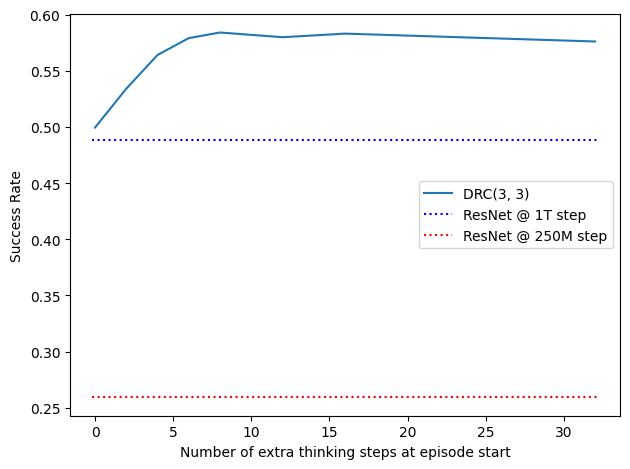

In [23]:
# solves vs steps_to_think

env_names = ["valid_medium"] + (["unfiltered"] if unfil else [])
for i, log_dict in enumerate([val_log_dict] + ([unfil_log_dict] if unfil else [])):
    episode_successes = [log_dict[f"{step:02d}_episode_successes"] for step in steps_to_think]
    episode_returns = [log_dict[f"{step:02d}_episode_returns"] for step in steps_to_think]
    
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Number of extra thinking steps at episode start')
    ax1.set_ylabel('Success Rate')
    # add legend DRC
    ax1.plot(steps_to_think, episode_successes, color=color, label="DRC(3, 3)")
    ax1.tick_params(axis='y')

    # ax2 = ax1.twinx()

    # color = 'tab:red'
    # ax2.set_ylabel('episode_returns', color=color)
    # ax2.plot(steps_to_think, episode_returns, color=color)
    # ax2.tick_params(axis='y', labelcolor=color)
    x_min = 0.04
    x_max = 1 - x_min
    ax1.axhline(baseline_1t[0], x_min, x_max, color='blue', linestyle='dotted', label="ResNet @ 1T step")
    ax1.axhline(baseline_250m[0], x_min, x_max, color='red', linestyle='dotted', label="ResNet @ 250M step")

    plt.legend()
    # plt.legend(*([ x[i] for i in [0, 2, 1] ] for x in plt.gca().get_legend_handles_labels()),
    #     # handletextpad=0.75,
    #     loc='best',
    # )

    fig.tight_layout()
    # plt.title()
    plt.show()

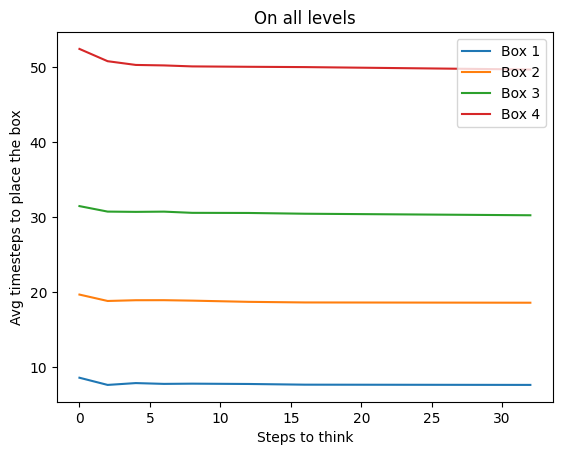

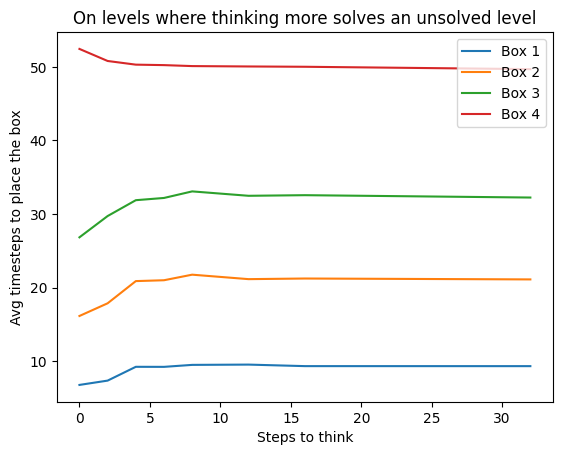

In [24]:
# Time to place boxes vs steps to think
reward_for_placing_box = 0.9
reward_for_placing_last_box = -0.1 + 1.0 + 10.0


for condition_on_improved_levels in [False, True]:
    time_across_think_steps = []
    for j in range(len(steps_to_think)):
        all_rewards = val_all_episode_info[j]["episode_rewards"]
        if condition_on_improved_levels:
            time_for_placing_boxes = [np.where(all_rewards[level_idx] == reward_for_placing_box)[0] for level_idx in improved_level_list]
        else:
            time_for_placing_boxes = [np.where(reward_array == reward_for_placing_box)[0] for reward_array in all_rewards]
        avg_time_box_placed = [np.mean([t[box_idx] for t in time_for_placing_boxes if len(t) > box_idx]) for box_idx in range(3)]
        time_for_placing_last_box = [np.where(reward_array == reward_for_placing_last_box)[0] for reward_array in all_rewards]
        time_for_placing_last_box = [e for e in time_for_placing_last_box if len(e) > 0]
        avg_time_box_placed.append(np.mean(time_for_placing_last_box))
        time_across_think_steps.append(avg_time_box_placed)

    plt.plot(steps_to_think, time_across_think_steps)
    plt.legend(["Box 1", "Box 2", "Box 3", "Box 4"])
    plt.xlabel("Steps to think")
    plt.ylabel("Avg timesteps to place the box")
    if condition_on_improved_levels:
        plt.title("On levels where thinking more solves an unsolved level")
    else:
        plt.title("On all levels")
    plt.show()


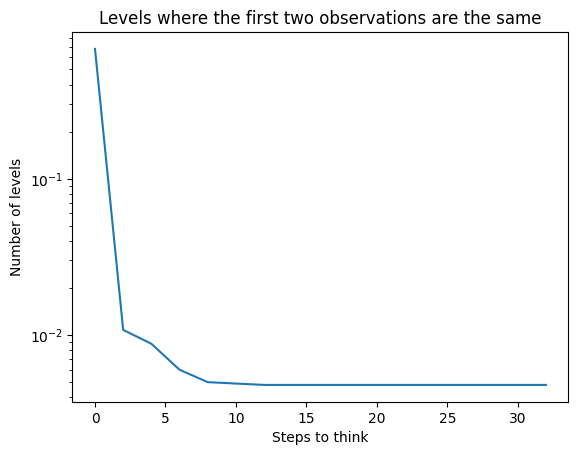

In [11]:
# same first obs vs steps to think
same_obs_list = []
for j in range(len(steps_to_think)):
    all_obs = val_all_episode_info[j]["episode_obs"]
    same_obs = [np.all(all_obs[level_idx][0] == all_obs[level_idx][1]) for level_idx in range(len(all_obs))]
    if j == 0:
        levels_with_same_obs = same_obs
    same_obs_list.append(np.mean(same_obs))

plt.plot(steps_to_think, same_obs_list)
plt.xlabel("Steps to think")
plt.ylabel("Number of levels")
plt.title("Levels where the first two observations are the same")
# log scale
plt.yscale("log")
plt.show()

### Correlation with A* difficulty (# of search steps)

In [12]:
all_level_infos = list(zip(val_all_episode_info[0]["level_infos"]["level_file_idx"], val_all_episode_info[0]["level_infos"]["level_idx"]))
all_search_steps = []
all_optimal_lengths = []
all_optimal_actions = []
for i, (file_idx, lev_idx) in enumerate(all_level_infos):
    filename = f"/training/.sokoban_cache/boxoban-levels-master/medium/valid/logs/log_{file_idx:03d}_{lev_idx}.csv"
    with open(filename, "r") as f:
        line = f.read().strip()
    line = line.split(",")
    all_search_steps.append(int(line[-1]))
    all_optimal_actions.append(line[-3])
    try:
        all_optimal_lengths.append(int(line[-2]))
    except ValueError:
        all_optimal_lengths.append(len(line[-3]))
    


5000


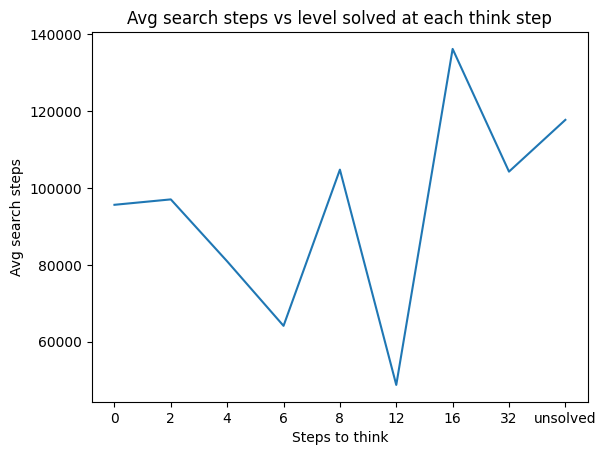

In [13]:
levels_partition_by_think_steps = [[] for _ in range(len(steps_to_think)+1)]
print(len(val_all_episode_info[0]["episode_successes"]))
for i in range(len(val_all_episode_info[0]["episode_successes"])):
    found = False
    for j in range(len(steps_to_think)):
        if val_all_episode_info[j]["episode_successes"][i]:
            levels_partition_by_think_steps[j].append(i)
            found = True
            break
    if not found:
        levels_partition_by_think_steps[-1].append(i)

# plot avg search steps for each partition
avg_search_steps = [np.mean([all_search_steps[level_idx] for level_idx in partition]) for partition in levels_partition_by_think_steps]
plt.plot(steps_to_think + ["unsolved"], avg_search_steps)
plt.xlabel("Steps to think")
plt.ylabel("Avg search steps")
plt.title("Avg search steps vs level solved at each think step")
plt.show()

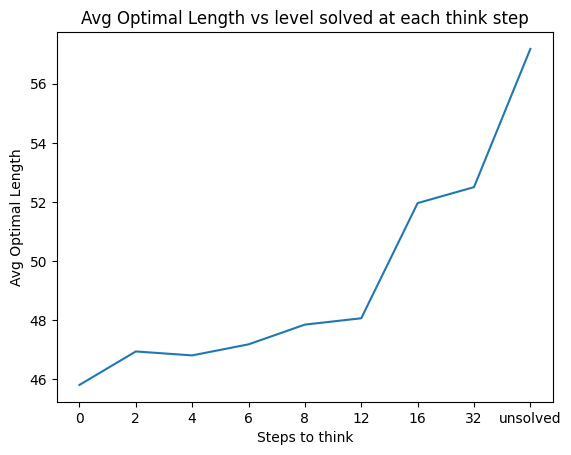

In [14]:
avg_opt_len = [np.mean([all_optimal_lengths[level_idx] for level_idx in partition]) for partition in levels_partition_by_think_steps]
plt.plot(steps_to_think + ["unsolved"], avg_opt_len)
plt.xlabel("Steps to think")
plt.ylabel("Avg Optimal Length")
plt.title("Avg Optimal Length vs level solved at each think step")
plt.show()

### Cycles at the start

In [16]:
cycle_starts_within = 5
max_cycles = np.zeros(len(val_all_episode_info[0]["episode_obs"]), dtype=int)
for i in range(len(val_all_episode_info[0]["episode_obs"])):
    all_obs = val_all_episode_info[0]["episode_obs"][i]
    all_obs = all_obs.reshape(all_obs.shape[0], 1, *all_obs.shape[1:])
    obs_repeat = np.all(all_obs == all_obs.transpose(1, 0, 2, 3, 4), axis=(2, 3, 4))
    np.fill_diagonal(obs_repeat, False)
    obs_repeat = [np.where(obs_repeat[j])[0] for j in range(min(cycle_starts_within, len(obs_repeat)))]
    obs_repeat = [abs(j-arr[-1]) for j, arr in enumerate(obs_repeat) if arr.size > 0]
    max_cycles[i] = np.max(obs_repeat) if len(obs_repeat) > 0 else 0


### Natural thinking steps using time to first box

In [ ]:
natural_thinking_steps = np.zeros(len(val_all_episode_info[0]["episode_obs"]), dtype=int)
box_on_target = np.array([254, 95, 56])[:, None, None]

def get_box_on_target_pos(obs):
    check_box_on_target = np.all(obs == box_on_target, axis=0)
    x_pos, y_pos = np.where(check_box_on_target)
    assert len(x_pos) == 1
    return (x_pos[0], y_pos[0])

for i in range(len(val_all_episode_info[0]["episode_obs"])):
    print(val_all_episode_info[baseline_steps]["episode_rewards"][i])
    print(val_all_episode_info[best_steps]["episode_rewards"][i])
    time_to_box1_wo_think_steps = np.where(val_all_episode_info[baseline_steps]["episode_rewards"][i] == reward_for_placing_box)[0]
    
    time_to_box1_w_think_steps = np.where(val_all_episode_info[best_steps]["episode_rewards"][i] == reward_for_placing_box)[0]
    if len(time_to_box1_wo_think_steps) == 0 or len(time_to_box1_w_think_steps) == 0:
        continue
    time_to_box1_wo_think_steps = time_to_box1_wo_think_steps[0] + 1 # +1 to index correct obs
    time_to_box1_w_think_steps = time_to_box1_w_think_steps[0] + 1

    box_pos_wo_think_steps = get_box_on_target_pos(val_all_episode_info[baseline_steps]["episode_obs"][i][time_to_box1_wo_think_steps])
    box_pos_w_think_steps = get_box_on_target_pos(val_all_episode_info[best_steps]["episode_obs"][i][time_to_box1_w_think_steps])
    if box_pos_w_think_steps == box_pos_wo_think_steps:
        natural_thinking_steps[i] = time_to_box1_wo_think_steps - time_to_box1_w_think_steps
        assert natural_thinking_steps[i] >= 0

    if i > 1:
        break


KeyboardInterrupt: 

In [28]:
natural_thinking_steps[:8]

array([0, 0, 0, 0, 0, 0, 0, 0])

### Videos

In [17]:
# solved but better returns
do_save = False
if do_save:
    saved = 0
    for level_idx in solved_better_returns:
        if levels_with_same_obs[level_idx]:
            continue
        save_level_video(level_idx, base_dir="solved_but_better_returns/")
        saved += 1
        if saved >= 10:
            break

In [18]:
# solved with thinking more
if do_save:
    saved = 0
    for level_idx in improved_level_list:
        save_level_video(level_idx, base_dir="thinking_solves_unsolved/")
        saved += 1
        if saved >= 10:
            break

### Collapse

In [19]:
# writer = cleanba_impala.WandbWriter(args)
# param_queue = queue.Queue(maxsize=1)
# rollout_queue = queue.Queue(maxsize=1)
# learner_policy_version = 0
# unreplicated_params = train_state.params
# with cleanba_impala.initialize_multi_device(args) as runtime_info:
#     device_params = jax.device_put(unreplicated_params, runtime_info.local_devices[0])
#     param_queue.put((device_params, learner_policy_version))
#     prng_key = jax.random.PRNGKey(0)
#     cleanba_impala.rollout(
#         prng_key,
#         args,
#         runtime_info,
#         rollout_queue,
#         param_queue,
#         writer,
#         runtime_info.learner_devices,
#         0,
#         runtime_info.local_devices[0],
#     )

# import glob

# all_log_levels = []
# for filename in glob.glob("/training/.sokoban_cache/boxoban-levels-master/medium/valid/logs/*"):
#     try:
#         file_idx, lev_idx = (int(c) for c in filename.split("/")[-1].split(".")[0].split("_")[1:])
#     except ValueError:
#         continue
#     all_log_levels.append((file_idx, lev_idx))

# # find file_idx, lev_idx not in all_log_levels
# not_present = []
# for file_idx in range(50):
#     for lev_idx in range(1000):
#         if (file_idx, lev_idx) not in all_log_levels:
#             not_present.append((file_idx, lev_idx))
# len(not_present)